In [ ]:
#| default_exp vad

# Perform Voice Activity Detection (VAD)

We want to start with voice activity detection to make sure we are not cutting off words and sentences in the middle.
This should improve transcription reliability and make both the quantization and T2S model training easier.

**Usage:**  
```
python -m whisperspeech.vad https://huggingface.co/datasets/collabora/librilight-webdataset/resolve/main/librilight-large-wo6454-flac-000002.tar
```

You can pass in either a URL or a local file name. The result will go into a file in the current directory named after the source file but replacing `flac` with `vad` (check the `flac_to_vad_name` function).

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| exporti
import os
import random
import torch
import torchaudio

from pathlib import Path
from fastprogress import progress_bar
from fastcore.script import call_parse

import numpy as np
import webdataset as wds

import whisperx

from whisperspeech.inference import get_compute_device
from whisperspeech import utils

In [ ]:
from IPython.display import HTML
import pylab as plt

In [ ]:
#| exporti
# some of the original file names have a dot in their name
# webdataset does not like it so let's patch it
def fix_dots_in_names(name):
    name, ext = name.rsplit('.', 1)
    return ".".join((name.replace('.', '_'), ext))

def load_dataset(url, decode=True):
    ds = wds.WebDataset(url)
    if not decode: return ds
    return ds.compose(
        wds.decode(utils.torch_audio_opus),
        utils.find_audio,
    )

We use the voice activity detection model from WhisperX (but we don't use their merging algorithm):

In [ ]:
#| exporti
def extract_segments(vad_result, max_duration):
    binarize = whisperx.vad.Binarize(max_duration=max_duration)
    segments = binarize(vad_result)
    return [(x.start, x.end) for x in segments.get_timeline()]

def segment_audio(vad_model, audio, sr=16000):
    vad_result = vad_model({"waveform": audio, "sample_rate": sr})
    return extract_segments(vad_result, 30)

Test just a few files:

In [ ]:
ds = wds.WebDataset('/data2/libritts-r-raw-000000.tar').compose(wds.decode(wds.torch_audio))

In [ ]:
for x in ds: break
x

{'__key__': './dev-clean/1272/128104/1272_128104_000001_000000',
 '__url__': '/data2/libritts-r-raw-000000.tar',
 'normalized.txt': "A 'JOLLY' ART CRITIC",
 'original.txt': "A 'JOLLY' ART CRITIC",
 'wav': (tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0036, -0.0038, -0.0050]]),
  24000)}

In [ ]:
# test it locally
input:str  = 'https://huggingface.co/datasets/collabora/librilight-webdataset/resolve/main/librilight-large-wo6454-flac-000002.tar'
output:str = input.rsplit("/", 1)[1].replace('flac', 'vad') + ".gz"

ds = load_dataset(input)
vad_model = whisperx.vad.load_vad_model('cuda')

with wds.TarWriter(output) as sink:
    for s in progress_bar(ds, total=10):
        audio, sr = s['audio']
        assert(sr == 16000)
        sink.write({
            "__key__": s['__key__'],
            "vad.npy": np.array(segment_audio(vad_model, audio), dtype=np.float32)
        })
        
!ls -lh {output}
!tar tf {output}

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1+cu118. Bad things might happen unless you revert torch to 1.x.


-rw-r--r-- 1 root root 7.5K Sep 21 08:51 librilight-large-wo6454-vad-000002.tar.gz
large/10089/five_minutes_stories_1508_librivox_64kb_mp3/5minutesstories_03_molesworth_64kb.vad.npy
large/10089/five_minutes_stories_1508_librivox_64kb_mp3/5minutesstories_04_molesworth_64kb.vad.npy
large/10089/five_minutes_stories_1508_librivox_64kb_mp3/5minutesstories_08_molesworth_64kb.vad.npy
large/10089/five_minutes_stories_1508_librivox_64kb_mp3/5minutesstories_09_molesworth_64kb.vad.npy
large/10089/five_minutes_stories_1508_librivox_64kb_mp3/5minutesstories_10_molesworth_64kb.vad.npy
large/10089/five_minutes_stories_1508_librivox_64kb_mp3/5minutesstories_11_molesworth_64kb.vad.npy
large/10089/goodcheerstories_1511_librivox_64kb_mp3/goodcheerstories_13_dickinson_64kb.vad.npy
large/10089/goodcheerstories_1511_librivox_64kb_mp3/goodcheerstories_30_dickinson_64kb.vad.npy
large/10089/mothers_nursery_tales_1512_librivox_64kb_mp3/mothers_nursery_tales_16_pyle_64kb.vad.npy
large/10089/mothers_nursery_tales

## Batch processing

Let's put everything above together.

In [ ]:
#| exporti
def flac_to_vad_name(input, key='audio'):
    if '-flac-' in input:
        return input.rsplit("/", 1)[1].replace('flac', 'vad') + ".gz"
    else:
        return input.rsplit("/", 1)[1].replace(key, 'vad') + ".gz"

@call_parse
def process_shard(
    input:str,           # input shard URL/path
    output:str=None,     # output shard URL/path
    key:str='audio',     # string to replace with 'vad' in the shard name
):
    if output is None: output = flac_to_vad_name(input, key=key)
    
    ds = load_dataset(input)
    dl = torch.utils.data.DataLoader(ds, num_workers=2, batch_size=None)
    vad_model = whisperx.vad.load_vad_model(get_compute_device())
    
    tmp = output+".tmp"
    with wds.TarWriter(tmp) as sink:
        for s in progress_bar(dl, total='noinfer'):
            audio, sr = s['audio']
            sink.write({
                "__key__": s['__key__'],
                "vad.npy": np.array(segment_audio(vad_model, audio, sr=sr), dtype=np.float32),
            })
    os.rename(tmp, output)

In [ ]:
# for reference, this was the performance on a single 4090:
process_shard('https://huggingface.co/datasets/collabora/librilight-webdataset/resolve/main/librilight-small-flac-000000.tar')

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1+cu118. Bad things might happen unless you revert torch to 1.x.


In [ ]:
for x in wds.WebDataset('/data2/libritts-r-vad-000000.tar').decode(): break
x['__key__'].split('/')

['.', 'dev-clean', '1272', '128104', '1272_128104_000001_000000']

(array([1.6967e+04, 0.0000e+00, 6.4500e+02, 0.0000e+00, 0.0000e+00,
        1.0800e+02, 0.0000e+00, 2.5000e+01, 0.0000e+00, 7.0000e+00]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

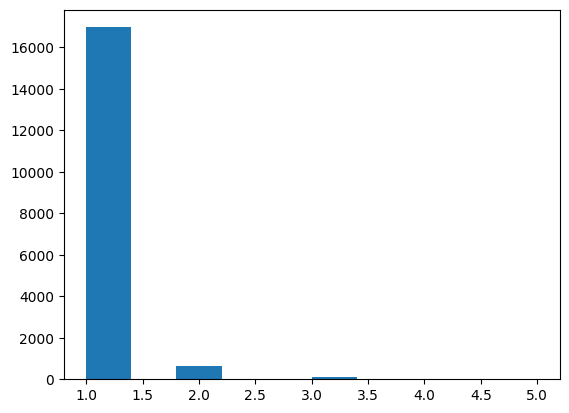

In [ ]:
plt.hist([x['vad.npy'].shape[0] for x in wds.WebDataset('/data2/libritts-r-vad-000000.tar').decode()])